In [1]:

using Plots, CSV, DataFrames, Polynomials, LinearAlgebra, Statistics

include("../../../datatools.jl")

combine_df_vectors

### Procedure
1. Parse data

The spline algorithms only work if the x-values of the data are in ascending order. This also means that if, in the same data recording, I walk forward, and then backwards, the algorithm won't work. To account for this we will sort the data

In [78]:
# This will create a dataframe from our file
filename = "../../../data/03-26-Stadium/Location.csv"
data = CSV.File(open(filename)) |> DataFrame

# using the longitude as our x-values and the altitude as our y-values
# dataframes makes it easy to get these values by using the dot syntax

#USE LATITUDE FOR X-VALUES IN OUR TESTING (THIS DATA IS TAKEN GOING E-W, not N-S)
x = data.longitude;
y = data.altitude;


Let me plot the original data to show you what I mean 

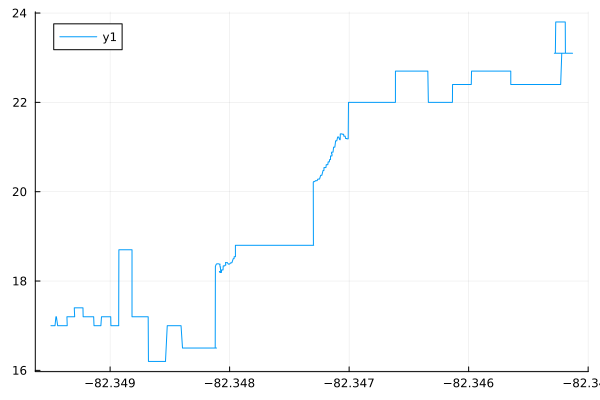

In [79]:
plot(x, y)

Do you see that at the top right?

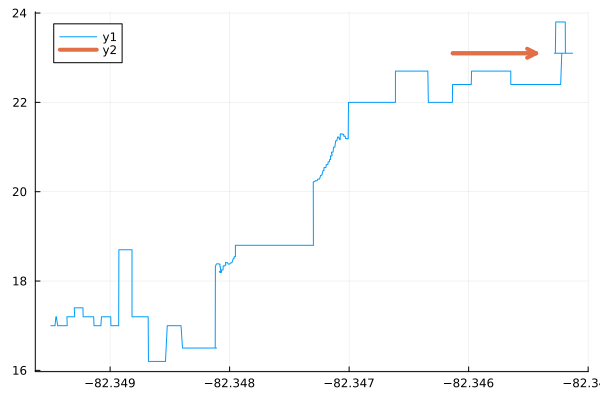

In [80]:
plot!([x[200], x[50]], [y[5], y[5]], arrow=true, l=4)

We don't want loops like that, it's hard for the algorithm to build fitting functions when they occur

In [81]:
#sort the x values to account for any wobble in the data
# x_sorted = sort(x, rev=true);

2. Sample some points from the sorted data

In [82]:
"""
    get_spaced_nodes(x, y, n=10; rev=true)

Takens in x and y values. returns 'n' number of spaced out points from the data.
By default this will return evenly spaced points, but setting fluctuation=SOME_INT will 
cause each index to fluctuate by ± the inputted value
"""
function get_spaced_nodes(x, y, n=10; fluctuation::Int=0)
     len = length(x)
     indices = round.(Int, LinRange(1, len, n))


     for i = 2:length(indices)-1
        indices[i] += rand((-1 * fluctuation):fluctuation)
     end
    
    #  @show indices

     if !issorted(x)
          sort!(x)
     end
           
     xs = x[indices]
     ys = y[indices]

     return xs, ys
 end

get_spaced_nodes

In [83]:
xs, ys = get_spaced_nodes(x, y);

indices = [1, 104, 207, 310, 413, 517, 620, 723, 826, 929]


3. Setup cubic interpolation method

This is taken directly from the textbook, it appears to be working currently. He uses a different naming convention. To convert --> 
His '$t$' == my '$xs$'  ,   His '$y$' == my '$ys$'

This takes in a sample and returns a function that fits these samples. To plot, we feed into the returned function our data points

In [84]:
"""
    spinterp(t,y)

Construct a cubic not-a-knot spline interpolating function for data
values in `y` given at nodes in `t`.
"""
function spinterp(t,y)
    n = length(t)-1
    h = [ t[k+1]-t[k] for k in 1:n ]

    # Preliminary definitions.
    Z = zeros(n,n);
    In = I(n);  E = In[1:n-1,:];
    J = diagm(0=>ones(n),1=>-ones(n-1))
    H = diagm(0=>h)

    # Left endpoint interpolation:
    AL = [ In Z Z Z ]
    vL = y[1:n]

    # Right endpoint interpolation:
    AR = [ In H H^2 H^3 ];
    vR = y[2:n+1]

    # Continuity of first derivative:
    A1 = E*[ Z J 2*H 3*H^2 ]
    v1 = zeros(n-1)

    # Continuity of second derivative:
    A2 = E*[ Z Z J 3*H ]
    v2 = zeros(n-1)

    # Not-a-knot conditions:
    nakL = [ zeros(1,3*n) [1 -1 zeros(1,n-2)] ]
    nakR = [ zeros(1,3*n) [zeros(1,n-2) 1 -1] ]

    # Assemble and solve the full system.
    A = [ AL; AR; A1; A2; nakL; nakR ]
    v = [ vL; vR; v1; v2; 0; 0 ]
    z = A\v

    # Break the coefficients into separate vectors.
    rows = 1:n
    a = z[rows]
    b = z[n.+rows];  c = z[2*n.+rows];  d = z[3*n.+rows]
    S = [ Polynomial([a[k],b[k],c[k],d[k]]) for k in 1:n ]

    # This function evaluates the spline when called with a value
    # for x.
    return function (x)
        if x < t[1] || x > t[n+1]    # outside the interval
            return NaN
        elseif x==t[1]
            return y[1]
        else
            k = findlast(x .> t)    # last node to the left of x
            return S[k](x-t[k])
        end
    end
end

spinterp

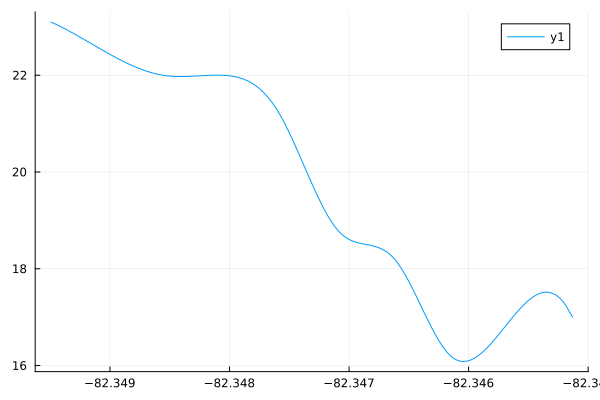

In [85]:
cspline_f = spinterp(xs, ys)
plot(x, cspline_f.(x))

Plotting it over top of our original data

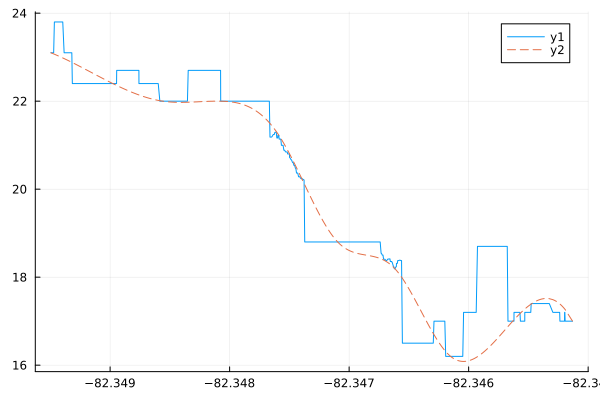

In [86]:
plt = plot(x, y)
plot!(plt, x, cspline_f.(x), ls=:dash)

Since I built the model using the sorted x-values, it's probably more accurate to show it overlaid on that plot instead

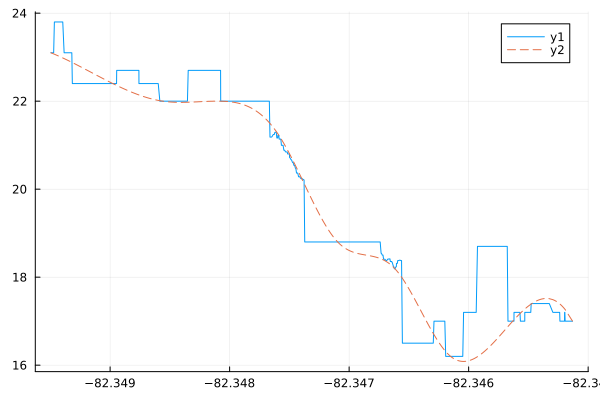

In [93]:
plt = plot(x, y)
plot!(plt, x, cspline_f.(x), ls=:dash)

4. Piece together into an easily usable function
   
I've opted for a function that plots an overlay of the spline onto a preexisting plot. I think this makes it easy to plot a bunch of splines at different values of n. It moreover allows for you to easily change the styling of the original plot without having to edit the function every time or pass in a bunch of parameters.

In [98]:
"""
     plot_cubic_spline(plt, x, y, n=10; la=0.6, fa=0.0)

Takes in a plot of the original data and overlays a cubic spline using `n` data points. If you want to shade the area between
the plots, set fa=[SOME VALUE 0.0-1.0]. You can also adjust how dark a line is by setting la=[SOME VALUE 0.0-1.0]
"""
function plot_cubic_spline(plt, x, y, n=10; la=0.6, fa=0.0)
     # x_sorted = sort(x, rev=true);
     xs, ys = get_spaced_nodes(x, y, n);
     cspline_f = spinterp(xs, ys)
     plot!(plt, x, cspline_f.(x), fillrange=y, fillalpha = fa, label="n=$n",ls=:dash, alpha=la)
end

plot_cubic_spline

indices = [1, 38, 75, 112, 149, 187, 224, 261, 298, 335, 372, 409, 446, 484, 521, 558, 595, 632, 669, 706, 743, 781, 818, 855, 892, 929]


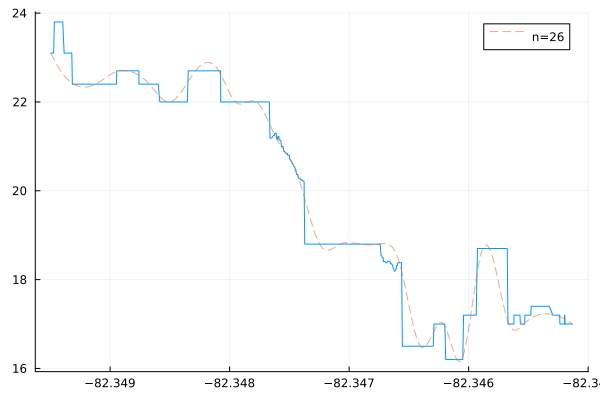

In [99]:
plt = plot(x, y, label=:none)
plot_cubic_spline(plt, x, y, 26)

Demo showing how to overlay multiple

indices = [1, 104, 207, 310, 413, 517, 620, 723, 826, 929]
indices = [1, 67, 134, 200, 266, 332, 399, 465, 531, 598, 664, 730, 796, 863, 929]
indices = [1, 50, 99, 148, 196, 245, 294, 343, 392, 441, 489, 538, 587, 636, 685, 734, 782, 831, 880, 929]


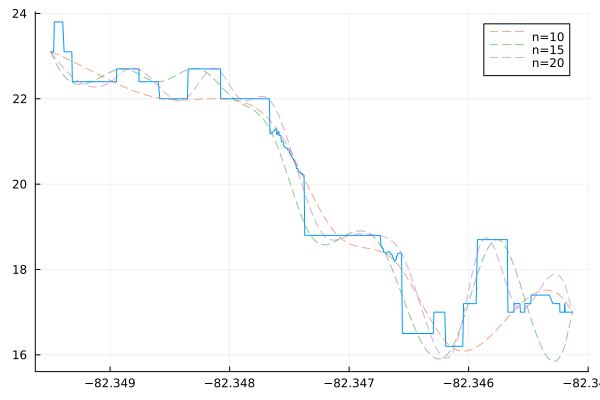

In [100]:
ns = [10, 15, 20]

plt = plot(x, y, label=:none)

for n in ns
     plot_cubic_spline(plt, x, y, n)
end

plt

Demo showing how to adjust shading and line alpha

indices = [1, 85, 170, 254, 338, 423, 507, 592, 676, 760, 845, 929]


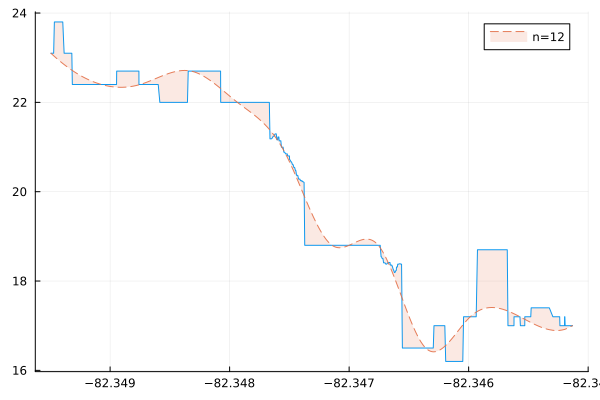

In [101]:
plt = plot(x, y, label=:none)
plot_cubic_spline(plt, x, y, 12; fa=0.15, la=0.9)

Let's first set up our notebook for data analysis

I need to include the necessary libraries, functions,  AND the file "datatools.jl" ,which contains a number of functions to aid in processing the data

In [2]:
# path to datatools.jl
include("../../../datatools.jl")
using Plots, CSV, DataFrames, Polynomials, LinearAlgebra, Statistics

In [8]:
"""
    spinterp(t,y)

Construct a cubic not-a-knot spline interpolating function for data
values in `y` given at nodes in `t`.
"""
function spinterp(t,y)
    n = length(t)-1
    h = [ t[k+1]-t[k] for k in 1:n ]

    # Preliminary definitions.
    Z = zeros(n,n);
    In = I(n);  E = In[1:n-1,:];
    J = diagm(0=>ones(n),1=>-ones(n-1))
    H = diagm(0=>h)

    # Left endpoint interpolation:
    AL = [ In Z Z Z ]
    vL = y[1:n]

    # Right endpoint interpolation:
    AR = [ In H H^2 H^3 ];
    vR = y[2:n+1]

    # Continuity of first derivative:
    A1 = E*[ Z J 2*H 3*H^2 ]
    v1 = zeros(n-1)

    # Continuity of second derivative:
    A2 = E*[ Z Z J 3*H ]
    v2 = zeros(n-1)

    # Not-a-knot conditions:
    nakL = [ zeros(1,3*n) [1 -1 zeros(1,n-2)] ]
    nakR = [ zeros(1,3*n) [zeros(1,n-2) 1 -1] ]

    # Assemble and solve the full system.
    A = [ AL; AR; A1; A2; nakL; nakR ]
    v = [ vL; vR; v1; v2; 0; 0 ]
    z = A\v

    # Break the coefficients into separate vectors.
    rows = 1:n
    a = z[rows]
    b = z[n.+rows];  c = z[2*n.+rows];  d = z[3*n.+rows]
    S = [ Polynomial([a[k],b[k],c[k],d[k]]) for k in 1:n ]

    # This function evaluates the spline when called with a value
    # for x.
    return function (x)
        if x < t[1] || x > t[n+1]    # outside the interval
            return NaN
        elseif x==t[1]
            return y[1]
        else
            k = findlast(x .> t)    # last node to the left of x
            return S[k](x-t[k])
        end
    end
end

spinterp

In [7]:
"""
     plot_cubic_spline(plt, x, y, n=10; la=0.6, fa=0.0)

Takes in a plot of the original data and overlays a cubic spline using `n` data points. If you want to shade the area between
the plots, set fa=[SOME VALUE 0.0-1.0]. You can also adjust how dark a line is by setting la=[SOME VALUE 0.0-1.0]
"""
function plot_cubic_spline(plt, x, y, n=10; la=0.6, fa=0.0)
     # x_sorted = sort(x, rev=true);
     xs, ys = get_spaced_nodes(x, y, n);
     cspline_f = spinterp(xs, ys)
     plot!(plt, x, cspline_f.(x), fillrange=y, fillalpha = fa, label="n=$n",ls=:dash, alpha=la)
end

plot_cubic_spline

### Procedure
1. Load in the data 
2. Apply any necessary tranformations to the data
3. Sample nodes from the data
4. Use nodes to create spline
5. Plot spline, compare against original data

---

##### Load in the data
I'll show how to do this for a single file, but I'll move to using the functions from 'datatools'

In [3]:
filename="../../../data/Sweetwater/Location-Justin-04-04_1.csv"
data = CSV.File(open(filename)) |> DataFrame

# using the latitude as our x-values and the altitude as our y-values
# dataframes make it easy to get these values by using the dot syntax

x = data.latitude;
y = data.altitude;

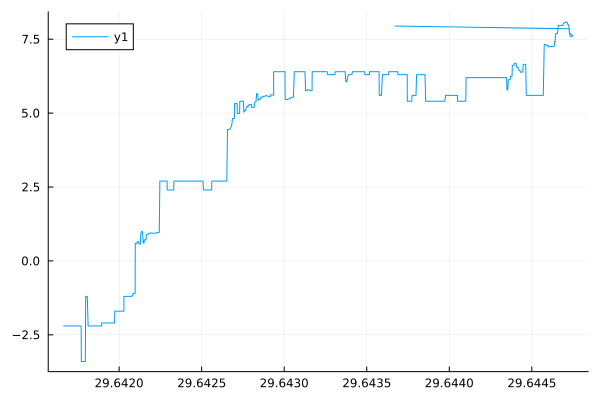

In [4]:
plot(x, y)

Look at the top right of the plot, see how it's all weird and not continuous. Idk really know why that is, but stuff like that will happen when we're collecting data by hand. An easy way around this is to sort the dataframe by latitudes

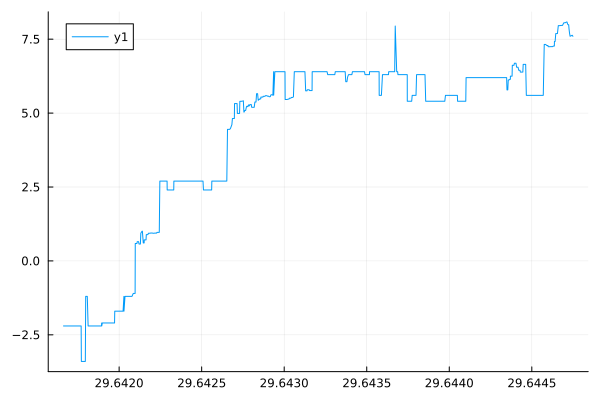

In [5]:
sort!(data, "latitude")

x = data.latitude;
y = data.altitude;

plot(x, y)

This helps get continuous data. But you can imagine that doing this process for each file may get cumbersome or confusing. Let's use some functions to make it a bit easier

In [6]:
sweetwater_dataframes = get_folder_dataframes("Sweetwater");

This creates a vector of dataframes for all the files in a directory.

---

##### Apply any necessary transformations
Our plan is ultimately to average out the samples. There is an issue, however. We are all recording data at different times, and traveling at different speeds. Moreover, the sensor logs position down to 15 decimal places. If I get 1000 data points, how likely is it all of your data is from the same 1000 positions? What about half that? A quarter? In my testing, the aforementioned errors resulted in having 0 common positions between samples. This means we have to be a little 'less precise'. If we round the values down to say 4-6 decimal places, we still retain a lot of precision, but we actually get similar positions. The following function will go through vector of dataframes and find those common values. 

In [52]:
filtered_sw_points = get_filtered_points(sweetwater_dataframes);

Note: this function also removes all the other columns, only "latitude", "longitude" and "altitude" are kept

Now we need to average these points together

In [53]:
sweetwater_avg_df = combine_df_vectors(filtered_sw_points);
x = sweetwater_avg_df.latitude;
y = sweetwater_avg_df.altitude;

---

##### Sample nodes from the data
By default the function I've made gets indices that equidistant. I believe that this is what is referred to as a box-spline. You can apply some noise to the indices if needed by adjusted 'fluctuations' in the function arguments 

In [54]:
xn, yn = get_spaced_nodes(x, y, 10);

---

##### Use nodes to create spline

In [55]:
cspline = spinterp(xn, yn);

---

##### Plot spline

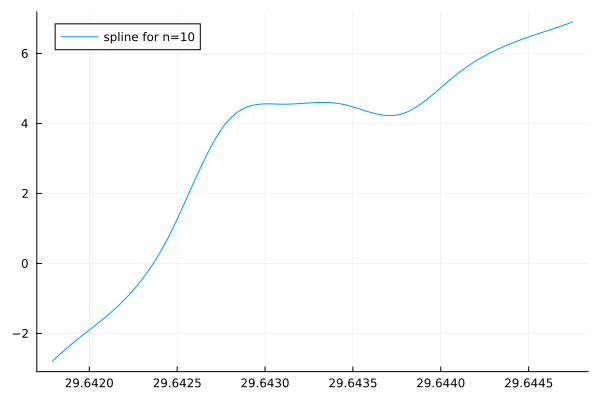

In [61]:
plot(x, cspline.(x), label="spline for n=10")

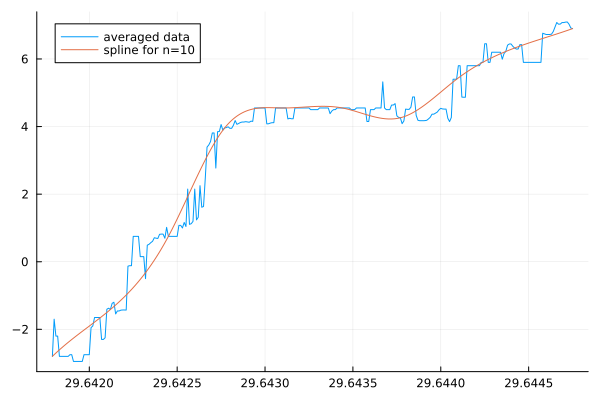

In [62]:
plt = plot(x, y, label="averaged data")
plot!(x, cspline.(x), label="spline for n=10")


For plotting the individual samples (especially at once), we can stack the dataframes in a given folder into one 

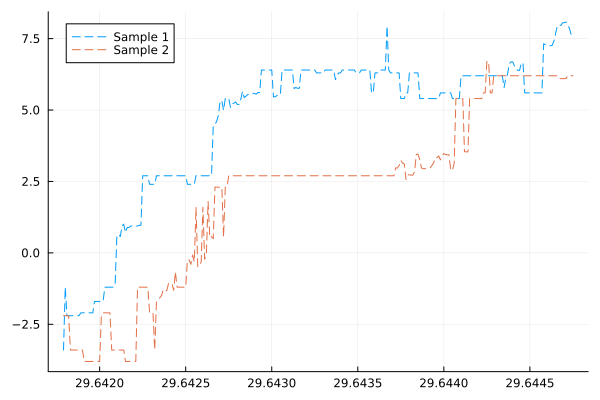

In [57]:
stacked_sw_df = stack_df_vectors(filtered_sw_points);

xs = stacked_sw_df.latitude;
ys = stacked_sw_df.altitude;

## The "sample" column is added in by the stack_df_vectors function
g = stacked_sw_df.sample;

plt = plot(xs, ys, group=g, ls=:dash)

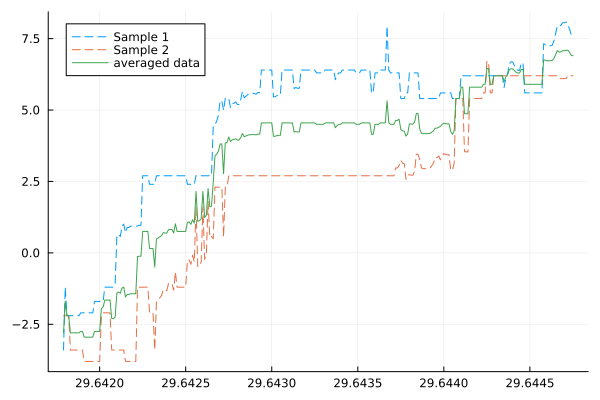

In [58]:
plot!(x, y, label="averaged data")

Lets plot a spline with some fill applied to 

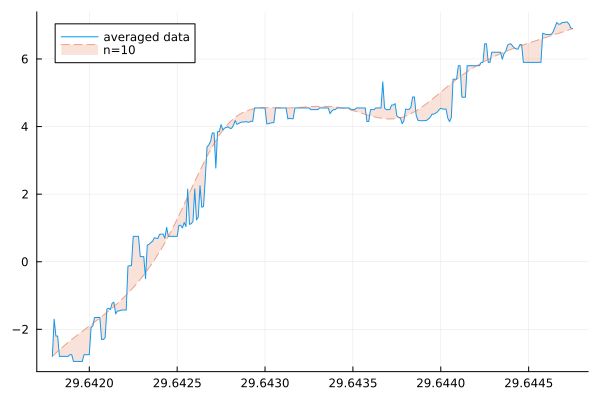

In [59]:
plt = plot(x, y, label="averaged data")

plot_cubic_spline(plt, x, y, 10; fa=0.2)

Now lets plot a bunch of lines

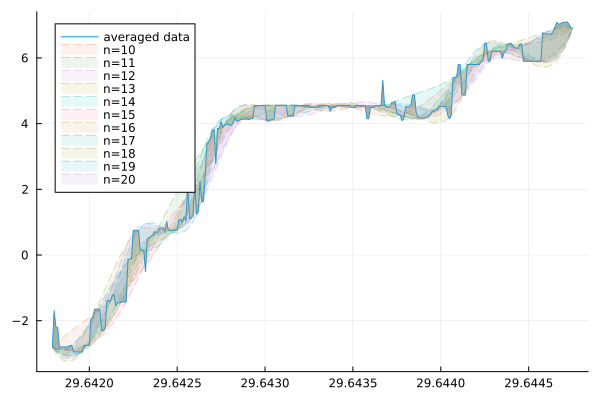

In [60]:
plt = plot(x, y, label="averaged data")

for n = 10:20
     plot_cubic_spline(plt, x, y, n; la=0.3, fa=0.1)
end

plt